In [10]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# What version of Python do you have?
import sys

import pandas as pd

import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.10.0

Python 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [3]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [11]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-01-17 23:51:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.1'

     0K ..........                                            100% 2.28M=0.004s

2024-01-17 23:51:04 (2.28 MB/s) - 'helper_functions.py.1' saved [10246/10246]



In [12]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA'
walk_through_dir(dataset)

There are 27 directories and 0 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA'.
There are 0 directories and 140 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA\1. Battery'.
There are 0 directories and 140 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA\10. USB_Port'.
There are 0 directories and 140 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA\11. Wifi_Card'.
There are 0 directories and 140 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA\12. Speaker'.
There are 0 directories and 140 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA\13. CMOS_Battery'.
There are 0 directories and 140 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA\14. Hard_Disk_Drive'.
There are 0 directories and 140 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA\15. Webcam'.
There are 0 directories and 140 images in 'E:/Web/HTMLSection3/400C/YoloV5classification/DATA\16. LCD_Screen'.
There are 0 directories 

In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [7]:
label_counts = image_df['Label'].value_counts()
print(label_counts)

Label
1. Battery                      140
22. Processor                   140
8. RAM                          140
7. Power_Switch                 140
6. Dc_Cable                     140
5. Motherboard                  140
4. Keyboard                     140
3. Hinge                        140
27. LVDS_DisplayRibbon_Cable    140
26. Sim_Slot                    140
25. Top_Panel                   140
24. Base_Panel                  140
23. RAM_Cover                   140
21. Touchpad                    140
10. USB_Port                    140
20. CPU_Fan                     140
2. DVD_Rom                      140
19. SSD                         140
18. Heatsink                    140
17. LCD_screen_panel_Bezel      140
16. LCD_Screen                  140
15. Webcam                      140
14. Hard_Disk_Drive             140
13. CMOS_Battery                140
12. Speaker                     140
11. Wifi_Card                   140
9. Screw_Kit                    140
Name: count, dtype: in

In [8]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [14]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.png")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

C:\Users\mehra\AppData\Local\Temp\ipykernel_17764\2361829875.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
C:\Users\mehra\AppData\Local\Temp\ipykernel_17764\2361829875.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


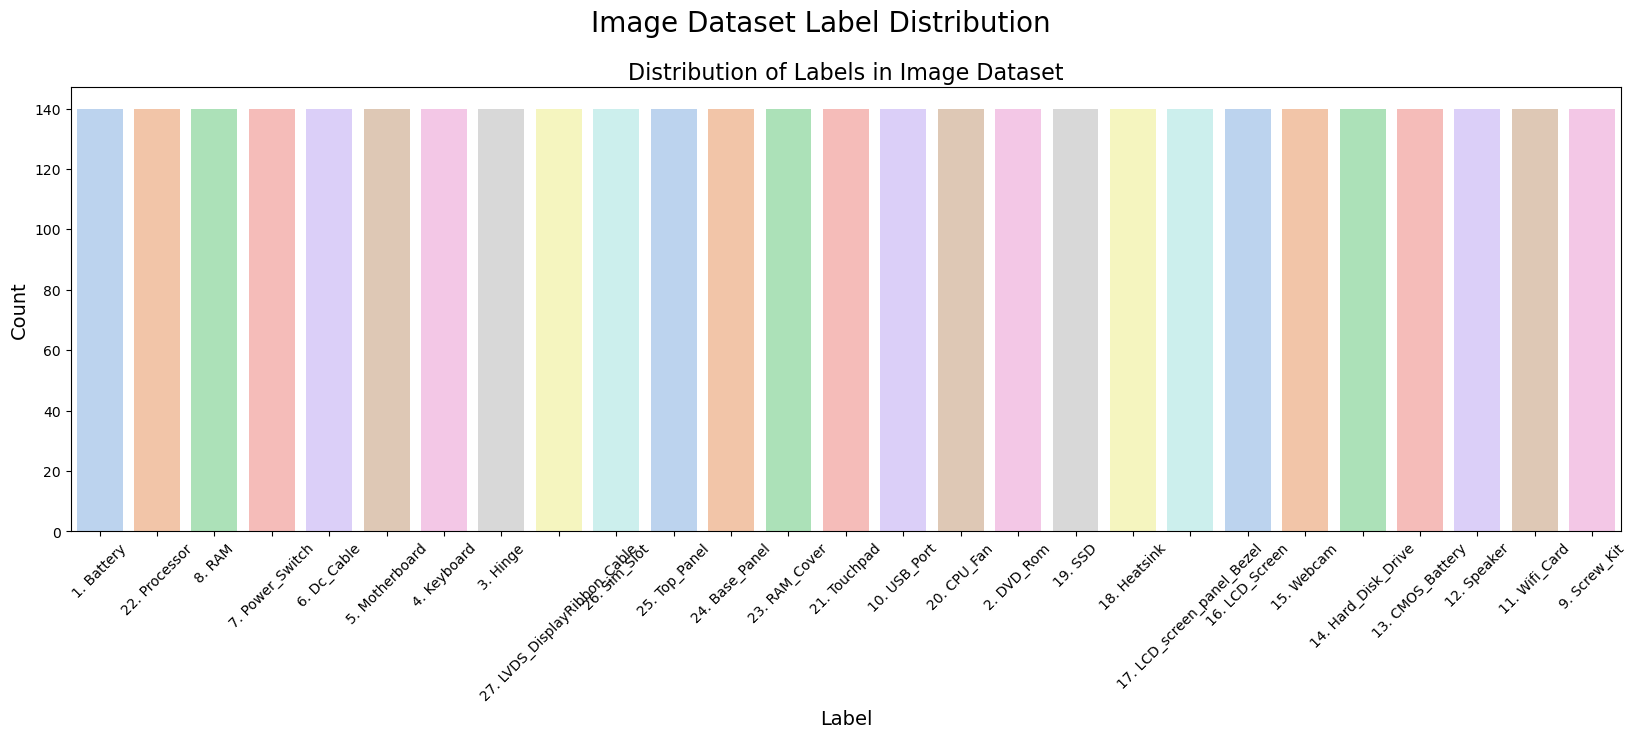

In [8]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

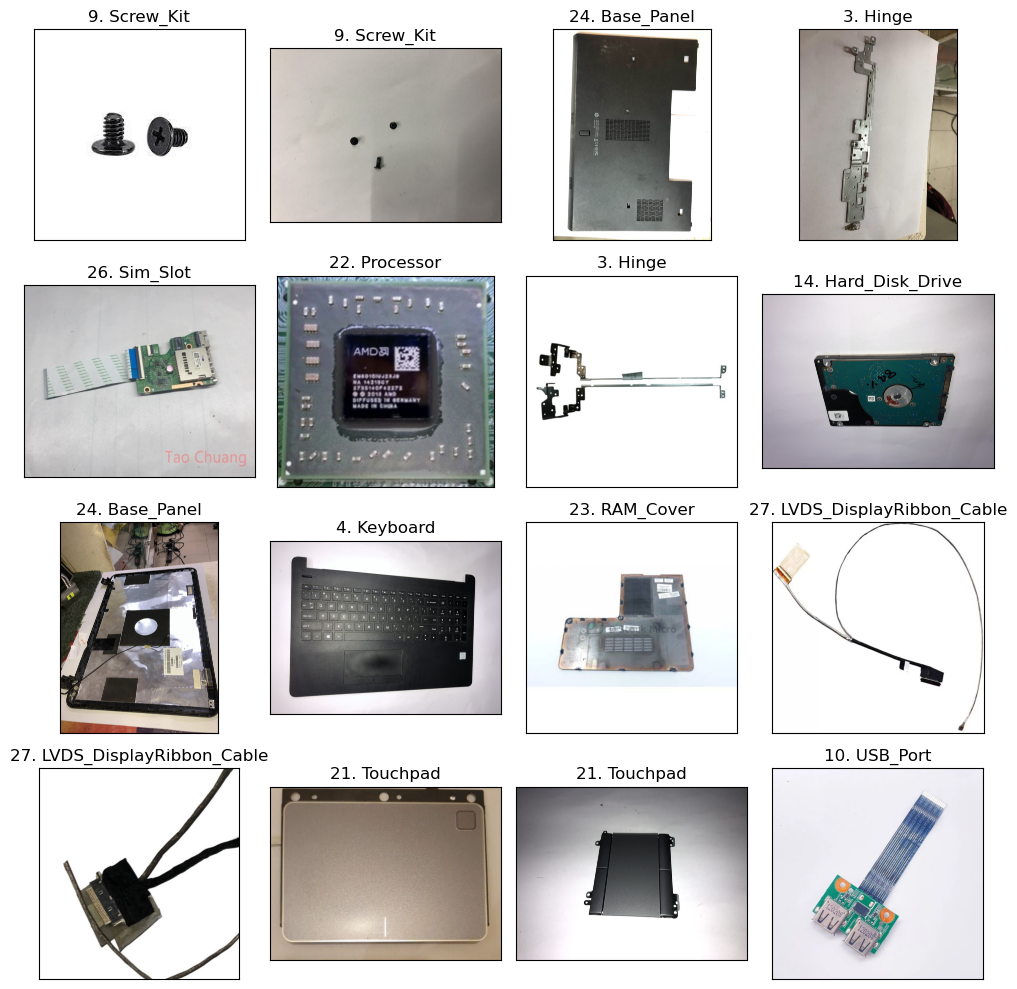

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [19]:
image_df

Filepath         Label
0    E:\Web\HTMLSection3\400C\YoloV5classification\...    1. Battery
1    E:\Web\HTMLSection3\400C\YoloV5classification\...    1. Battery
2    E:\Web\HTMLSection3\400C\YoloV5classification\...    1. Battery
3    E:\Web\HTMLSection3\400C\YoloV5classification\...    1. Battery
4    E:\Web\HTMLSection3\400C\YoloV5classification\...    1. Battery
..                                                 ...           ...
373  E:\Web\HTMLSection3\400C\YoloV5classification\...  9. Screw_Kit
374  E:\Web\HTMLSection3\400C\YoloV5classification\...  9. Screw_Kit
375  E:\Web\HTMLSection3\400C\YoloV5classification\...  9. Screw_Kit
376  E:\Web\HTMLSection3\400C\YoloV5classification\...    1. Battery
377  E:\Web\HTMLSection3\400C\YoloV5classification\...    1. Battery

[378 rows x 2 columns]

In [11]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=42)

In [12]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    validation_split=0.1,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
)

In [13]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
    
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3062 validated image filenames belonging to 27 classes.
Found 340 validated image filenames belonging to 27 classes.
Found 378 validated image filenames belonging to 27 classes.


In [14]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

In [15]:
# Load the pretained model
pretrained_model = tf.keras.applications.DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [16]:
# Create checkpoint callback
checkpoint_path = "laptop_classification_model_checkpoint_densenet201_27_run"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [17]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.15)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)


outputs = Dense(27, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [19]:
#DENSENET

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "laptop_classification_densenet201_1c"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/laptop_classification_densenet201_1c/20240117-031511
Epoch 1/100
28/96 [=======>......................] - ETA: 1:09 - loss: 6.4318 - accuracy: 0.0357

e:\minicondareal\envs\tensormain\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


96/96 [==============================] - 136s 1s/step - loss: 5.5855 - accuracy: 0.0425 - val_loss: 3.6953 - val_accuracy: 0.0647 - lr: 1.0000e-05
Epoch 2/100
96/96 [==============================] - 87s 897ms/step - loss: 4.3444 - accuracy: 0.0624 - val_loss: 3.2565 - val_accuracy: 0.0971 - lr: 1.0000e-05
Epoch 3/100
96/96 [==============================] - 90s 933ms/step - loss: 3.7789 - accuracy: 0.0869 - val_loss: 3.0177 - val_accuracy: 0.1559 - lr: 1.0000e-05
Epoch 4/100
96/96 [==============================] - 105s 1s/step - loss: 3.4581 - accuracy: 0.1208 - val_loss: 2.8512 - val_accuracy: 0.1794 - lr: 1.0000e-05
Epoch 5/100
96/96 [==============================] - 87s 901ms/step - loss: 3.2552 - accuracy: 0.1427 - val_loss: 2.7126 - val_accuracy: 0.2206 - lr: 1.0000e-05
Epoch 6/100
96/96 [==============================] - 87s 899ms/step - loss: 3.0626 - accuracy: 0.1675 - val_loss: 2.5890 - val_accuracy: 0.2971 - lr: 1.0000e-05
Epoch 7/100
96/96 [==============================]

In [20]:
model.save("densenet201_main_run2.h5")

In [25]:
#DENSENET

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "laptop_classification_densenet201_1c"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/laptop_classification_densenet201_1c/20240117-104714
Epoch 1/30
96/96 [==============================] - 87s 899ms/step - loss: 0.2301 - accuracy: 0.9353 - val_loss: 0.3349 - val_accuracy: 0.8853 - lr: 1.0000e-05
Epoch 2/30
96/96 [==============================] - 86s 886ms/step - loss: 0.2177 - accuracy: 0.9406 - val_loss: 0.3370 - val_accuracy: 0.8853 - lr: 1.0000e-05
Epoch 3/30
96/96 [==============================] - 86s 886ms/step - loss: 0.2171 - accuracy: 0.9406 - val_loss: 0.3336 - val_accuracy: 0.8853 - lr: 1.0000e-05
Epoch 4/30
96/96 [==============================] - 84s 879ms/step - loss: 0.2001 - accuracy: 0.9425 - val_loss: 0.3323 - val_accuracy: 0.8882 - lr: 1.0000e-05
Epoch 5/30
96/96 [==============================] - 84s 873ms/step - loss: 0.2019 - accuracy: 0.9438 - val_loss: 0.3318 - val_accuracy: 0.8824 - lr: 1.0000e-05
Epoch 6/30
96/96 [==============================] - 84s 877ms/step - loss: 0.1935 - accuracy: 0.9432

KeyboardInterrupt: 

In [26]:
training_history = history.history

In [27]:
with open('metrics.txt', 'w') as file:
    file.write("Training Accuracy: {}\n".format(training_history['accuracy']))
    file.write("Validation Accuracy: {}\n".format(training_history['val_accuracy']))
    file.write("Training Loss: {}\n".format(training_history['loss']))
    file.write("Validation Loss: {}\n".format(training_history['val_loss']))

In [28]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.22272
Test Accuracy: 94.18%


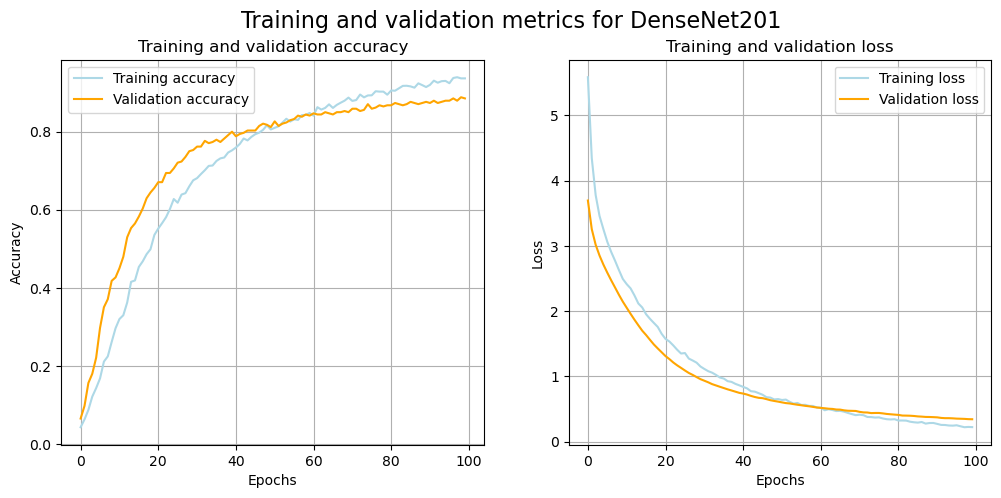

In [124]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training Accuracy and Validation Accuracy
ax1.plot(epochs, accuracy, 'lightblue', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Training Loss and Validation Loss
ax2.plot(epochs, loss, 'lightblue', label='Training loss')
ax2.plot(epochs, val_loss, 'orange', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Overall title for the entire figure
fig.suptitle('Training and validation metrics for DenseNet201', fontsize=16)
plt.show()
fig.savefig("E:/Web/HTMLSection3/400C/Main/DensetNet201/curves.png")

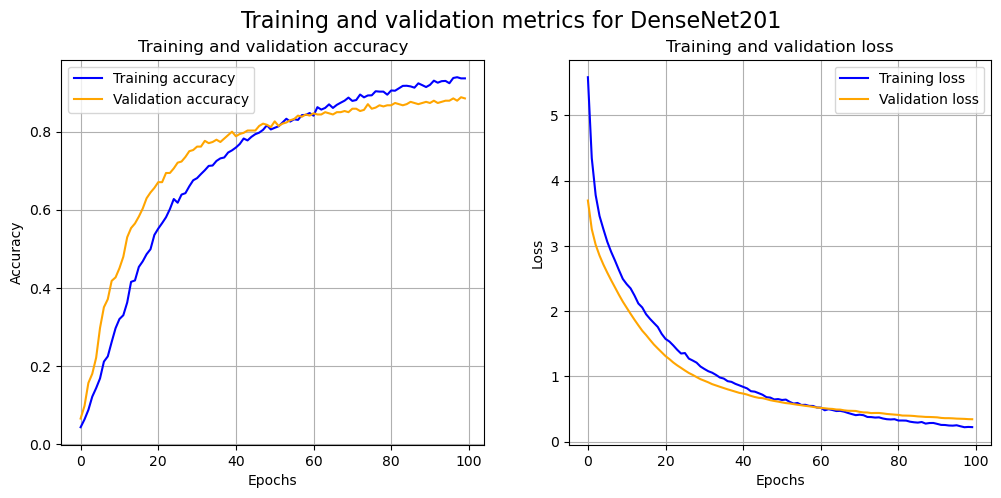

In [122]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training Accuracy and Validation Accuracy
ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Training Loss and Validation Loss
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'orange', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Overall title for the entire figure
fig.suptitle('Training and validation metrics for DenseNet201', fontsize=16)
plt.show()

In [38]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

12/12 [==============================] - 10s 805ms/step
The first 5 predictions: ['15. Webcam', '26. Sim_Slot', '15. Webcam', '3. Hinge', '17. LCD_screen_panel_Bezel']


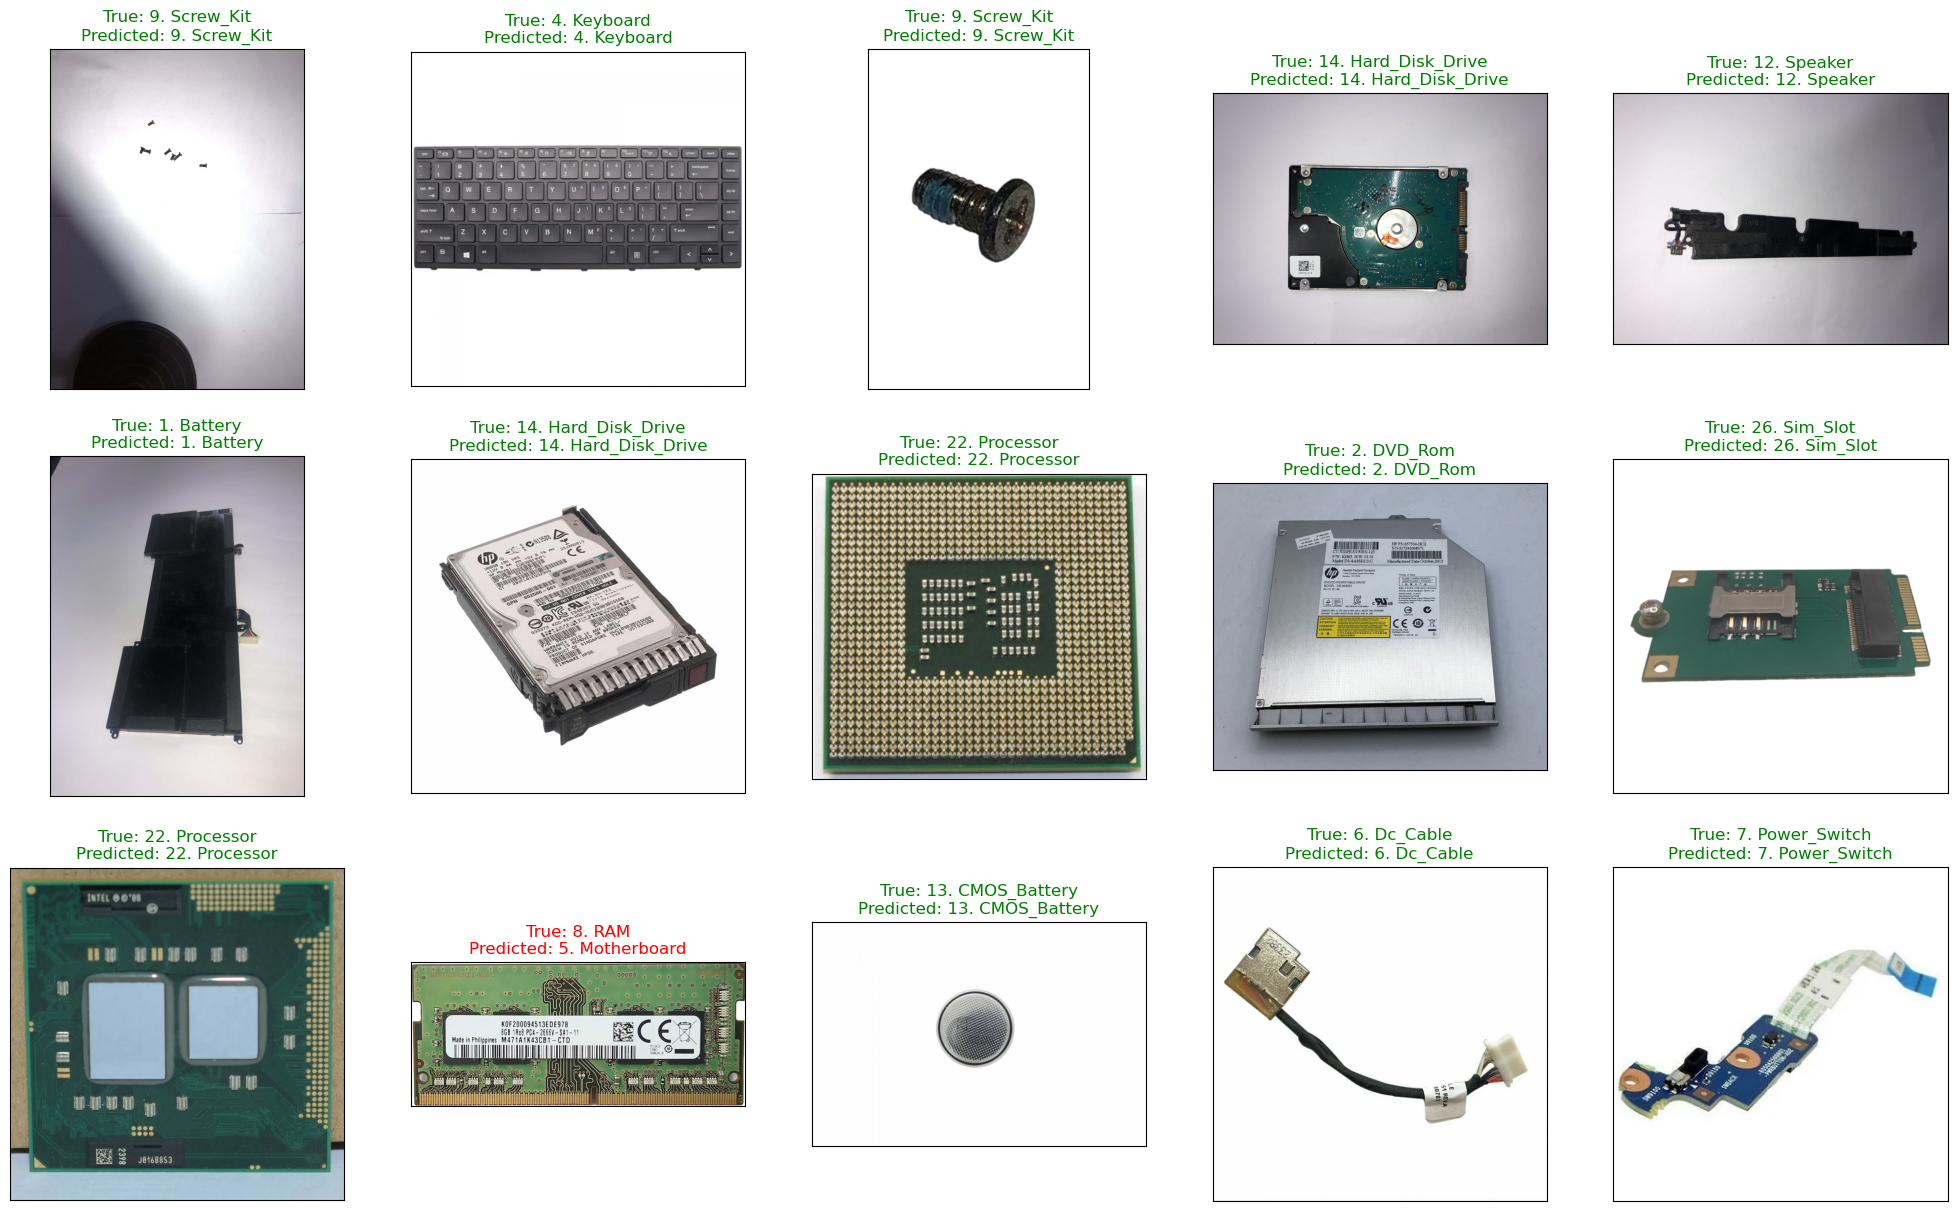

<Figure size 640x480 with 0 Axes>

In [40]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [48]:
model.save('resnet152v2_laptop.h5')

In [49]:
# Load the Keras model from the .h5 file
model_ld = tf.keras.models.load_model('resnet152V2_laptop.h5')

# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_ld)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
with open('resnet152V2_laptop_tfl.tflite', 'wb') as f:
    f.write(tflite_model)

In [41]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                              precision    recall  f1-score   support

                  1. Battery       0.89      1.00      0.94        17
                10. USB_Port       0.95      0.91      0.93        22
               11. Wifi_Card       0.94      0.89      0.92        19
                 12. Speaker       1.00      0.95      0.98        22
            13. CMOS_Battery       0.90      1.00      0.95         9
         14. Hard_Disk_Drive       0.94      1.00      0.97        15
                  15. Webcam       0.93      1.00      0.96        13
              16. LCD_Screen       0.88      1.00      0.93         7
  17. LCD_screen_panel_Bezel       1.00      1.00      1.00        20
                18. Heatsink       0.79      1.00      0.88        11
                     19. SSD       0.86      0.80      0.83        15
                  2. DVD_Rom       1.00      1.00      1.00        15
                 20. CPU_Fan       1.00      0.92      0.96        12
                21.

In [152]:
def report_generate(Y_test, predictions):
    report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = predictions, output_dict=True)).transpose()
    report = report.rename(index={'0': '1. Battery','1':'2. DVD_Rom','2':'3. Hinge', '3':'4. Keyboard', '4':'5. Motherboard', '5':'6. Dc_Cable',
                                  '6':'7. Power_Switch', '7':'8. RAM', '8':'9. Screw_Kit', '9':'10. USB_Port',  '10':'11. Wifi_Card', '11':'12. Speaker',
                                  '12':'13. CMOS_Battery','13':'14. Hard_Disk_Drive', '14':'15. Webcam','15':'16. LCD_Screen','16':'17. LCD_screen_panel_Bezel',
                                  '17':'18. Heatsink','18':'19. SSD', '19':'20. CPU_Fan','20':'21. Touchpad', '21':'22. Processor','22': '23. RAM_Cover',
                                  '23':'24. Base_Panel','24':'25. Top_Panel', '25':'26. Sim_Slot', '26':'27. LVDS_DisplayRibbon_Cable'})

    report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
    report=report.drop(["support"],axis=1)
    columns = ['precision','recall','f1-score']
    report.columns = columns
    plt = report.plot(kind='bar',figsize=(40,20))
    plot=plt.tick_params(rotation=40)
    plt.savefig("E:/Web/HTMLSection3/400C/Main/DensetNet201/f1 barplot.png")
    return plot,report


AttributeError: 'Axes' object has no attribute 'savefig'

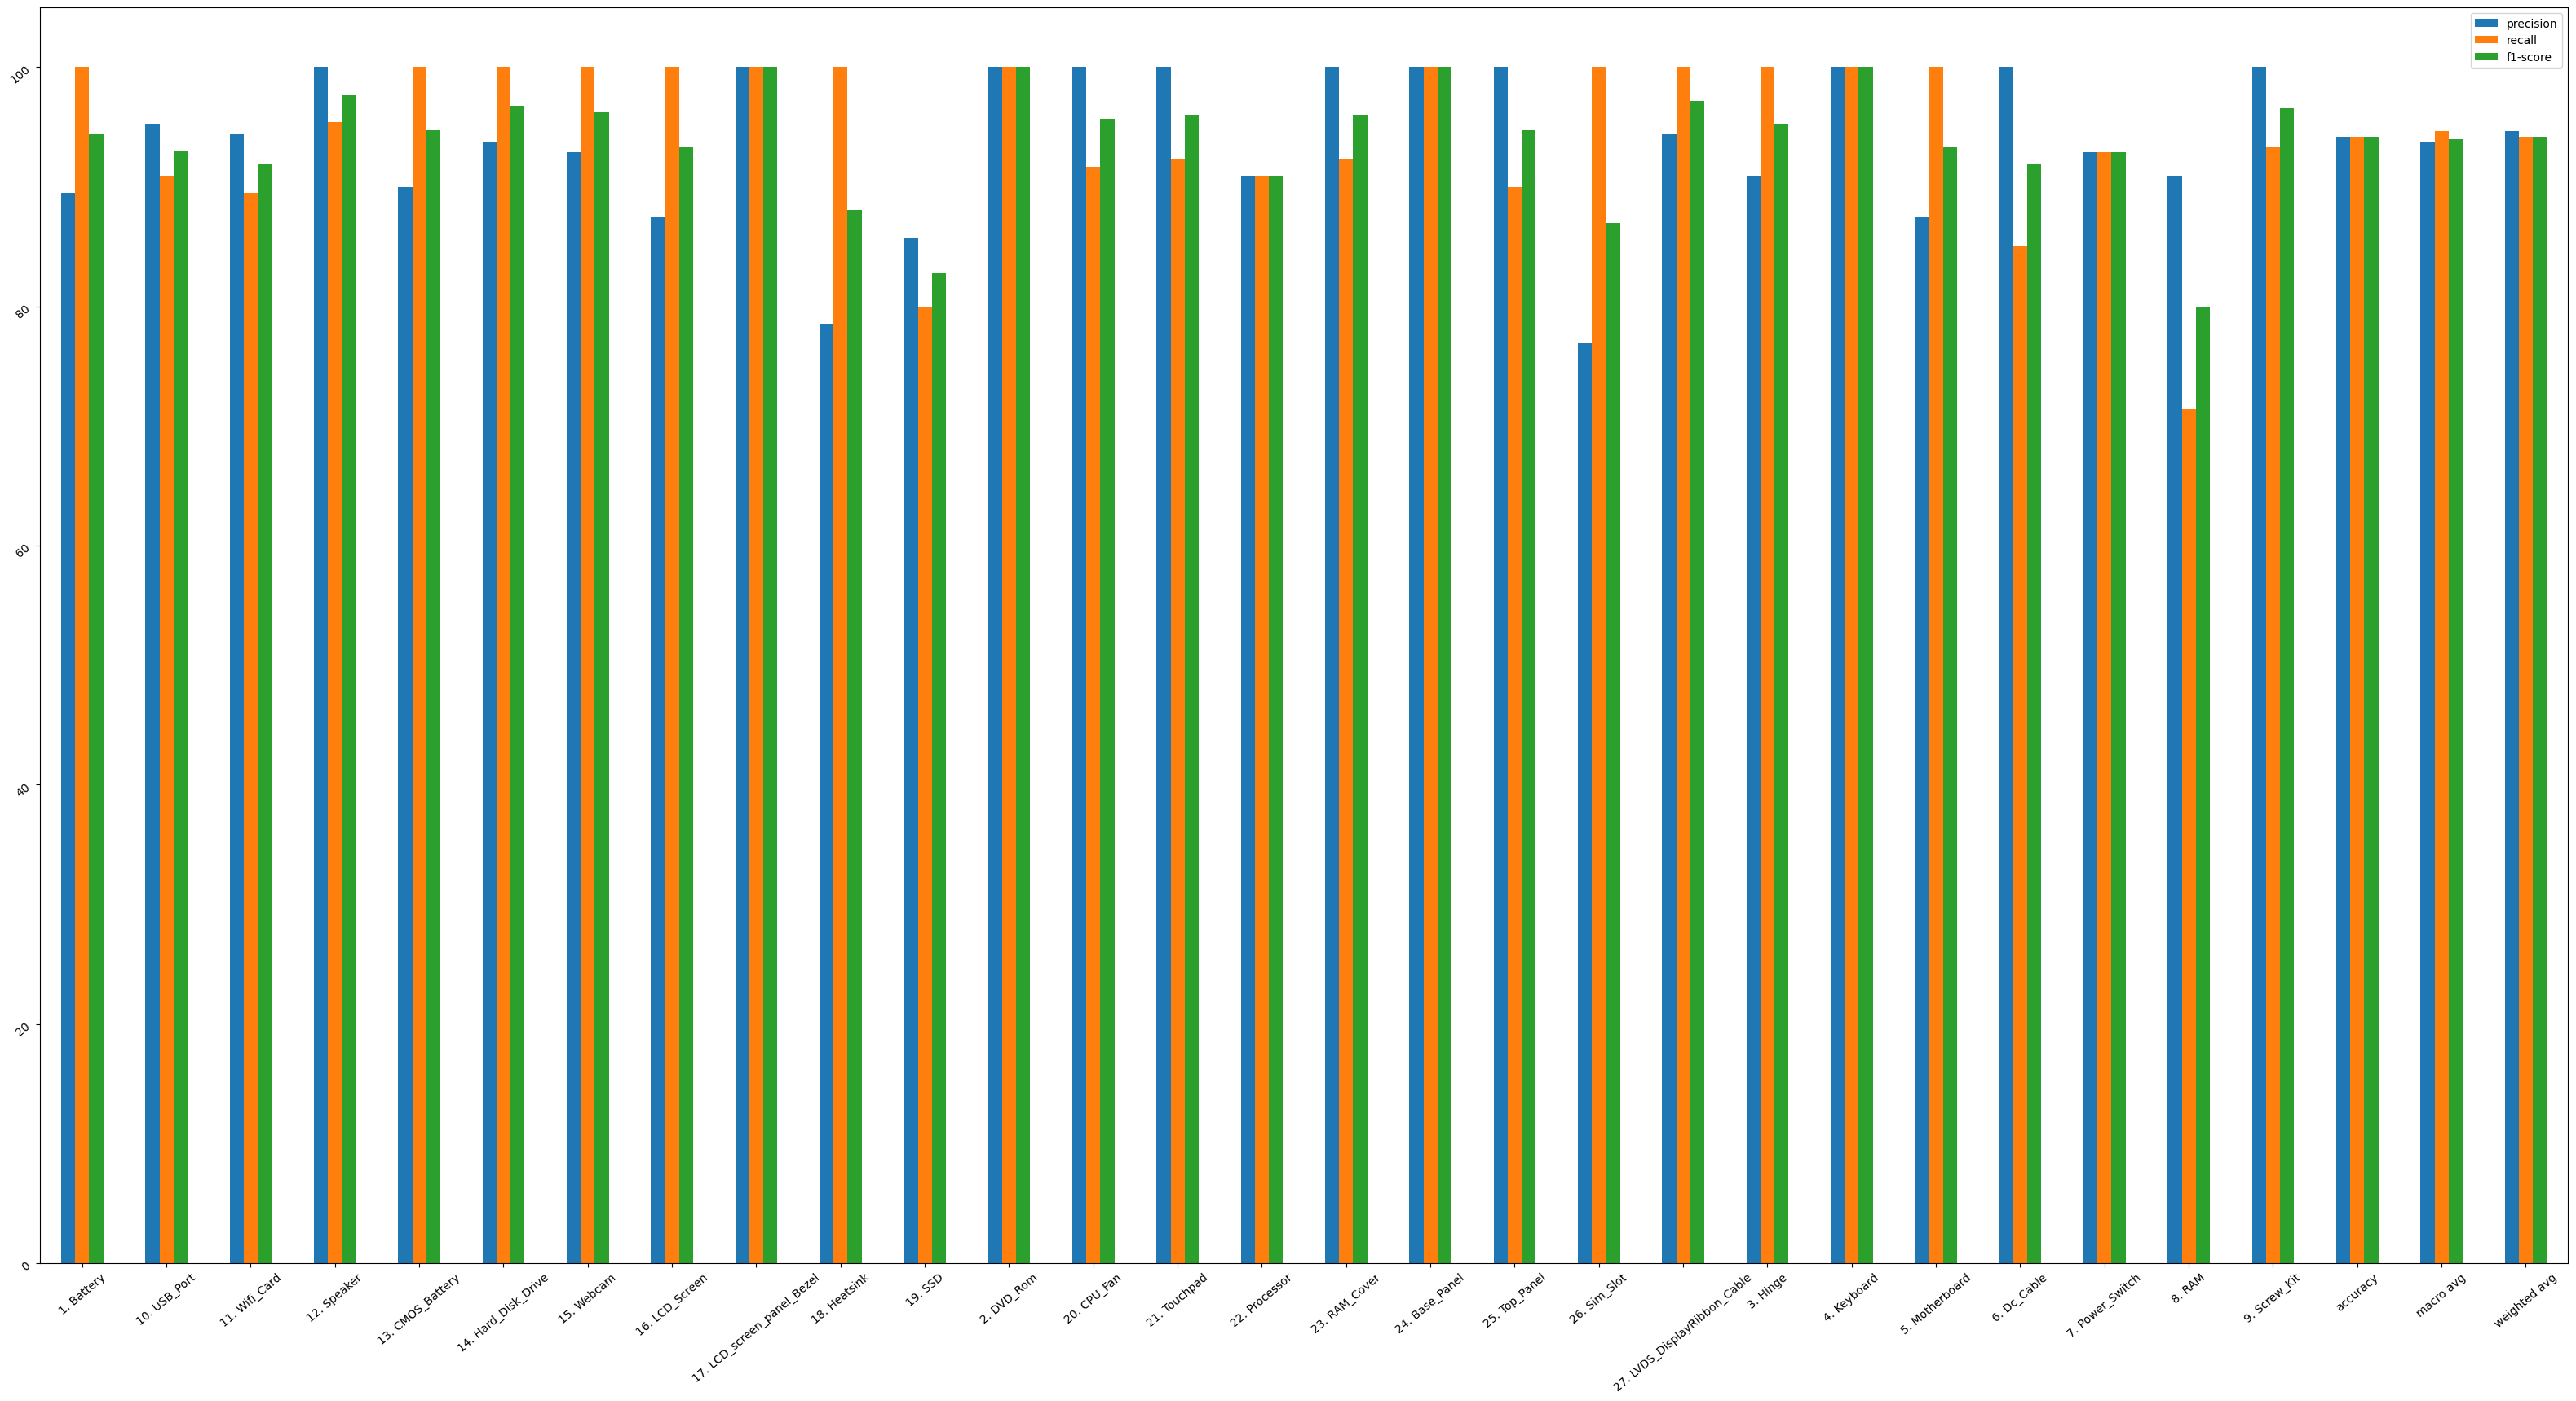

In [153]:
report_generate(y_test, pred)

In [35]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
1. Battery                     0.894737  1.000000  0.944444   17.000000
10. USB_Port                   0.952381  0.909091  0.930233   22.000000
11. Wifi_Card                  0.944444  0.894737  0.918919   19.000000
12. Speaker                    1.000000  0.954545  0.976744   22.000000
13. CMOS_Battery               0.900000  1.000000  0.947368    9.000000
14. Hard_Disk_Drive            0.937500  1.000000  0.967742   15.000000
15. Webcam                     0.928571  1.000000  0.962963   13.000000
16. LCD_Screen                 0.875000  1.000000  0.933333    7.000000
17. LCD_screen_panel_Bezel     1.000000  1.000000  1.000000   20.000000
18. Heatsink                   0.785714  1.000000  0.880000   11.000000
19. SSD                        0.857143  0.800000  0.827586   15.000000
2. DVD_Rom                     1.000000  1.000000  1.000000   15.000000
20. CPU_Fan                    1.000000  0.916667  0.956522   12.000000
21. Touchpad                   1.000000  0.923077  0.960000   13.000000
22. Processor                  0.909091  0.909091  0.909091   11.000000
23. RAM_Cover                  1.000000  0.923077  0.960000   13.000000
24. Base_Panel                 1.000000  1.000000  1.000000   16.000000
25. Top_Panel                  1.000000  0.900000  0.947368   10.000000
26. Sim_Slot                   0.769231  1.000000  0.869565   10.000000
27. LVDS_DisplayRibbon_Cable   0.944444  1.000000  0.971429   17.000000
3. Hinge                       0.909091  1.000000  0.952381   10.000000
4. Keyboard                    1.000000  1.000000  1.000000   11.000000
5. Motherboard                 0.875000  1.000000  0.933333    7.000000
6. Dc_Cable                    1.000000  0.850000  0.918919   20.000000
7. Power_Switch                0.928571  0.928571  0.928571   14.000000
8. RAM                         0.909091  0.714286  0.800000   14.000000
9. Screw_Kit                   1.000000  0.933333  0.965517   15.000000
accuracy                       0.941799  0.941799  0.941799    0.941799
macro avg                      0.937778  0.946536  0.939334  378.000000
weighted avg                   0.946183  0.941799  0.941526  378.000000

In [133]:
#confusion matrix
def conf_matrix(y_test, pred):
    cm = confusion_matrix(y_test, pred)
# Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                       index = ['1. Battery', '2. DVD_Rom', '3. Hinge', '4. Keyboard', '5. Motherboard', '6. Dc_Cable', '7. Power_Switch', '8. RAM', '9. Screw_Kit',
                                '10. USB_Port',  '11. Wifi_Card', '12. Speaker','13. CMOS_Battery', '14. Hard_Disk_Drive','15. Webcam','16. LCD_Screen',
                                '17. LCD_screen_panel_Bezel','18. Heatsink','19. SSD', '20. CPU_Fan','21. Touchpad', '22. Processor','23. RAM_Cover',
                                '24. Base_Panel','25. Top_Panel','26. Sim_Slot','27. LVDS_DisplayRibbon_Cable'],
                       columns = ['1. Battery', '2. DVD_Rom', '3. Hinge', '4. Keyboard', '5. Motherboard', '6. Dc_Cable', '7. Power_Switch', '8. RAM', '9. Screw_Kit',
                                '10. USB_Port',  '11. Wifi_Card', '12. Speaker','13. CMOS_Battery', '14. Hard_Disk_Drive','15. Webcam','16. LCD_Screen',
                                '17. LCD_screen_panel_Bezel','18. Heatsink','19. SSD', '20. CPU_Fan','21. Touchpad', '22. Processor','23. RAM_Cover',
                                '24. Base_Panel','25. Top_Panel','26. Sim_Slot','27. LVDS_DisplayRibbon_Cable'])
    
    fig=plt.figure(figsize=(30,20))
    sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
    plt.title="Confusion Matrix of DenseNet201",
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation = 75)
    plt.yticks(rotation = 20)
    plt.show()
    plt.close()
    
    fig.savefig("E:/Web/HTMLSection3/400C/Main/DensetNet201/confusion_matrix.png")


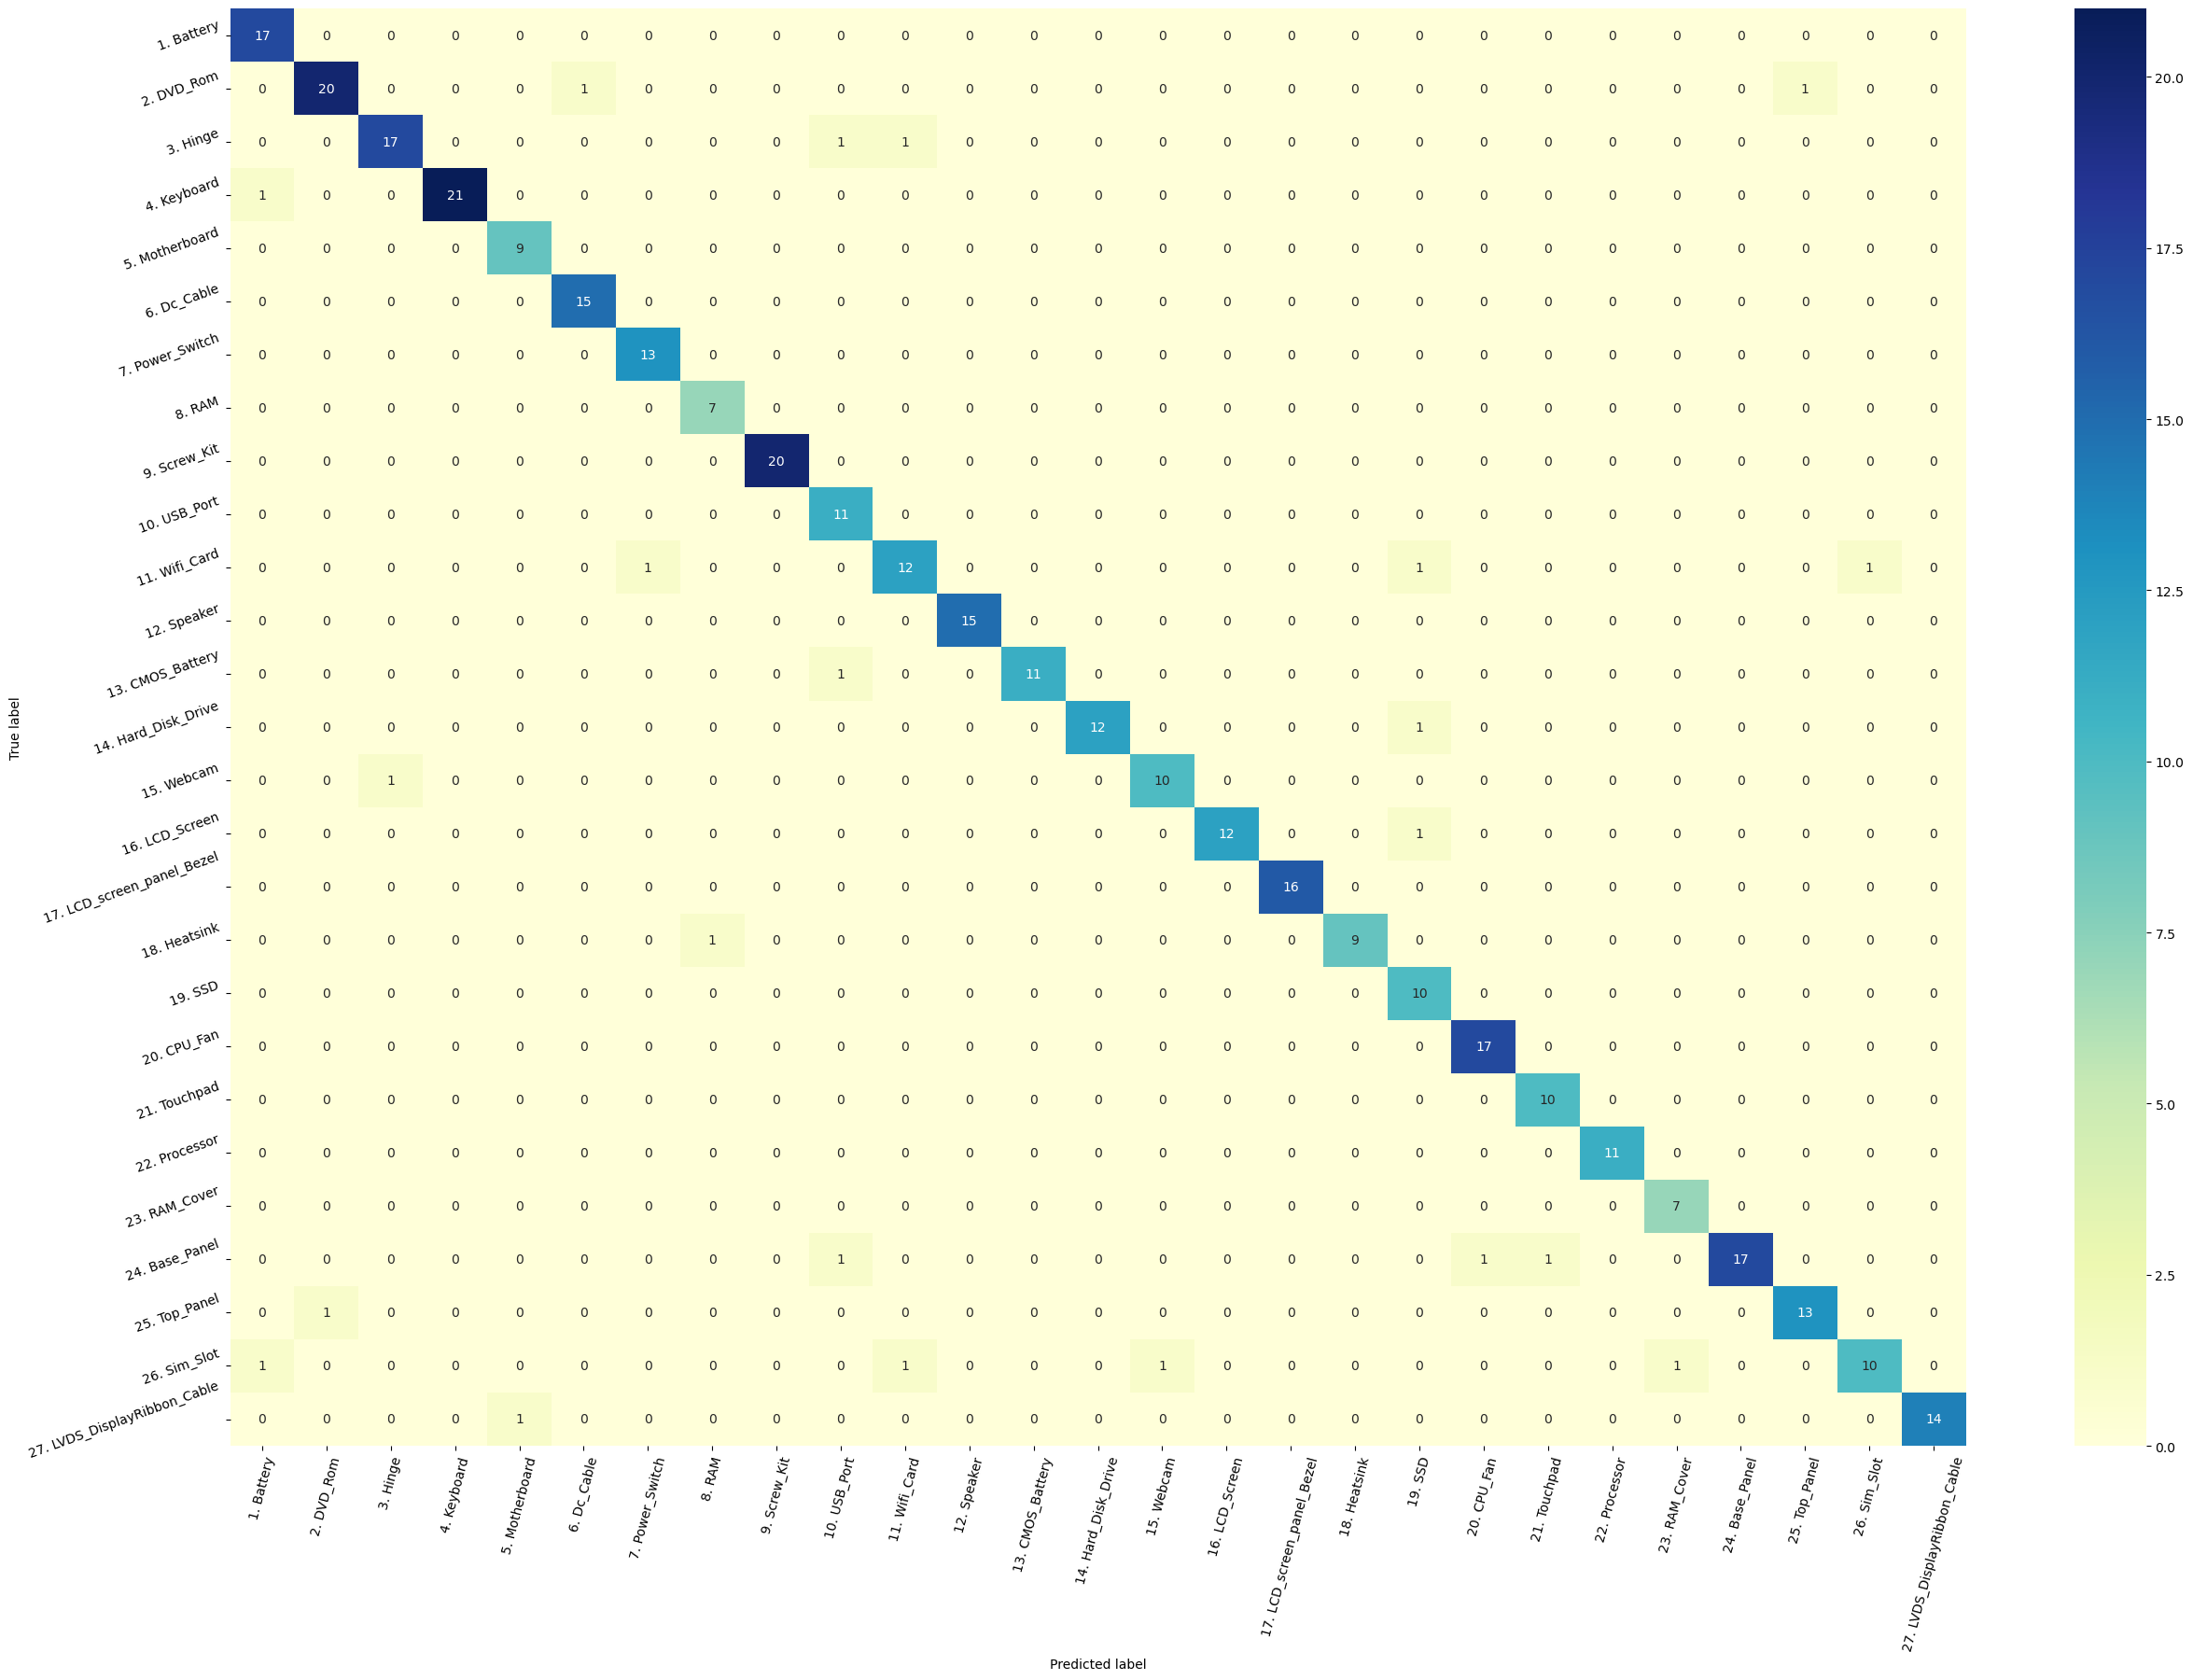

In [134]:
conf_matrix(y_test, pred)

In [65]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 15), text_size=10, norm=False, savefig=True): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    sorted_labels = sorted(labels)
    # Label the axes
    ax.set(title="Confusion Matrix of DenseNet201",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),  # create enough axis slots for each class
       yticks=np.arange(n_classes),
       xticklabels=sorted_labels,  # use the sorted labels
       yticklabels=sorted_labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("E:/Web/HTMLSection3/400C/Main/DensetNet201/confusion_matrix.png")

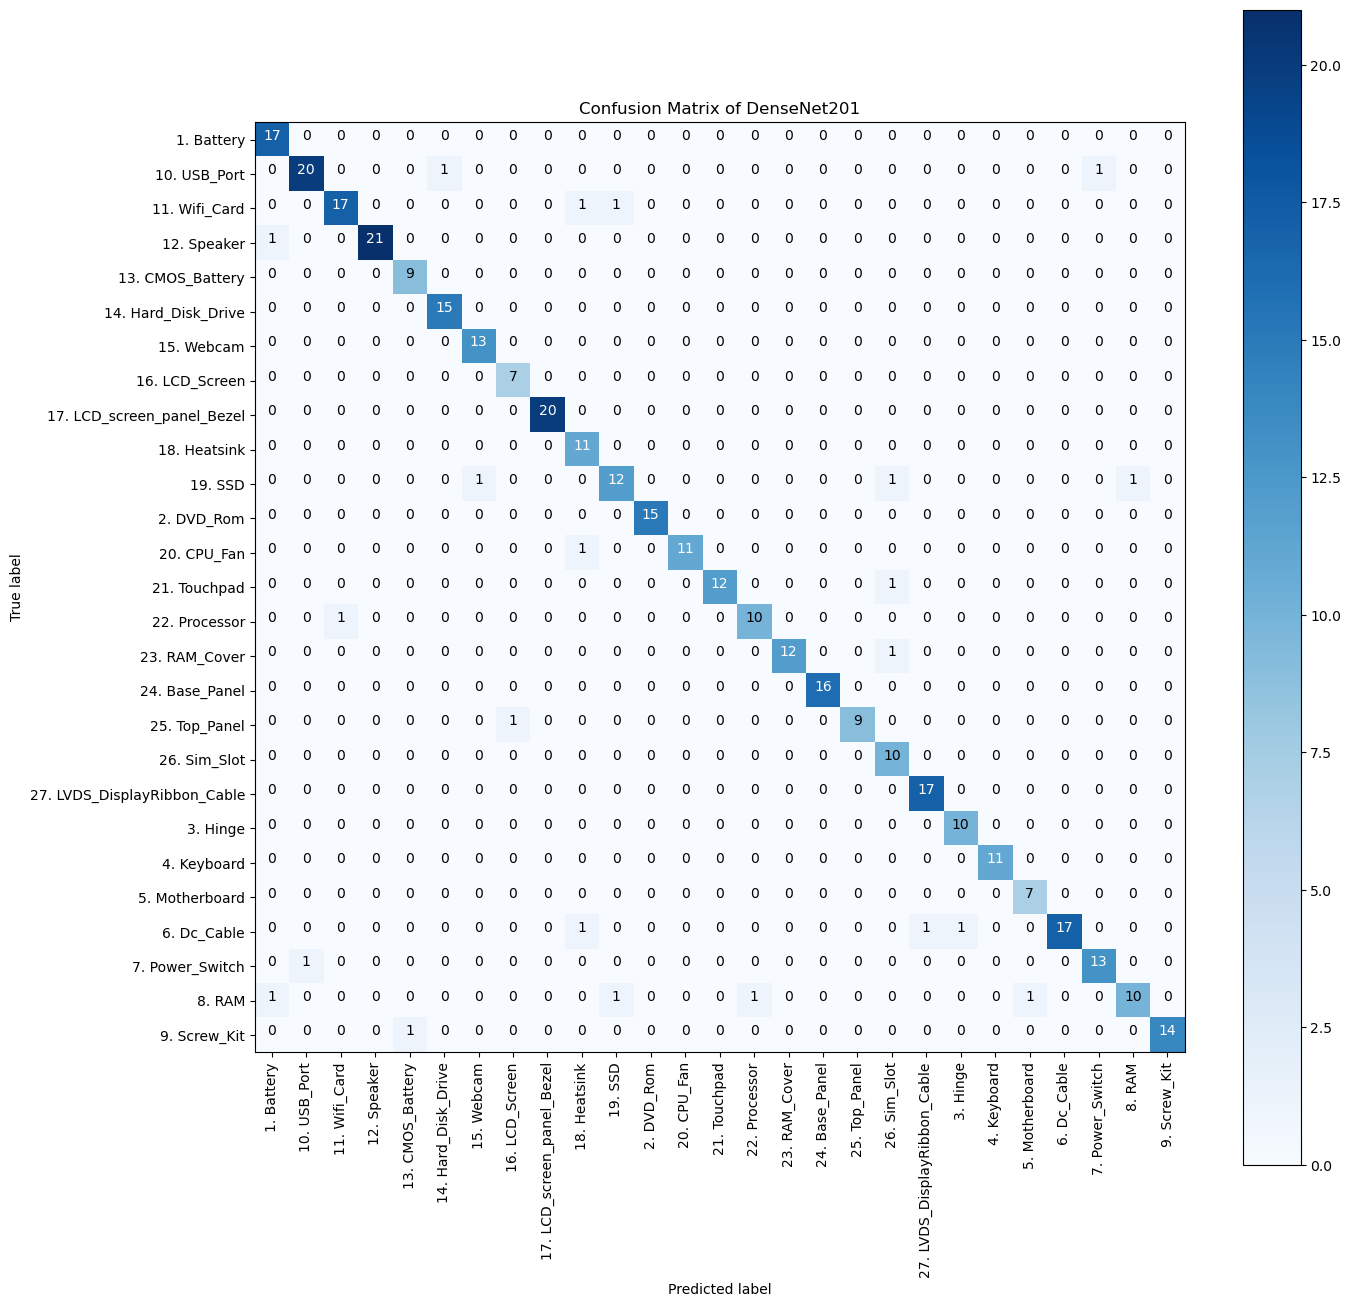

In [66]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [106]:
from sklearn.preprocessing import LabelBinarizer

In [108]:
categories= ['1. Battery', '10. USB_Port',  '11. Wifi_Card', '12. Speaker','13. CMOS_Battery','14. Hard_Disk_Drive',
             '15. Webcam','16. LCD_Screen','17. LCD_screen_panel_Bezel','18. Heatsink','19. SSD', '2. DVD_Rom','20. CPU_Fan',
             '21. Touchpad', '22. Processor','23. RAM_Cover','24. Base_Panel','25. Top_Panel','26. Sim_Slot','27. LVDS_DisplayRibbon_Cable',
             '3. Hinge', '4. Keyboard', '5. Motherboard', '6. Dc_Cable', '7. Power_Switch', '8. RAM', '9. Screw_Kit']

In [113]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

ROC AUC score: 0.9721518897344696


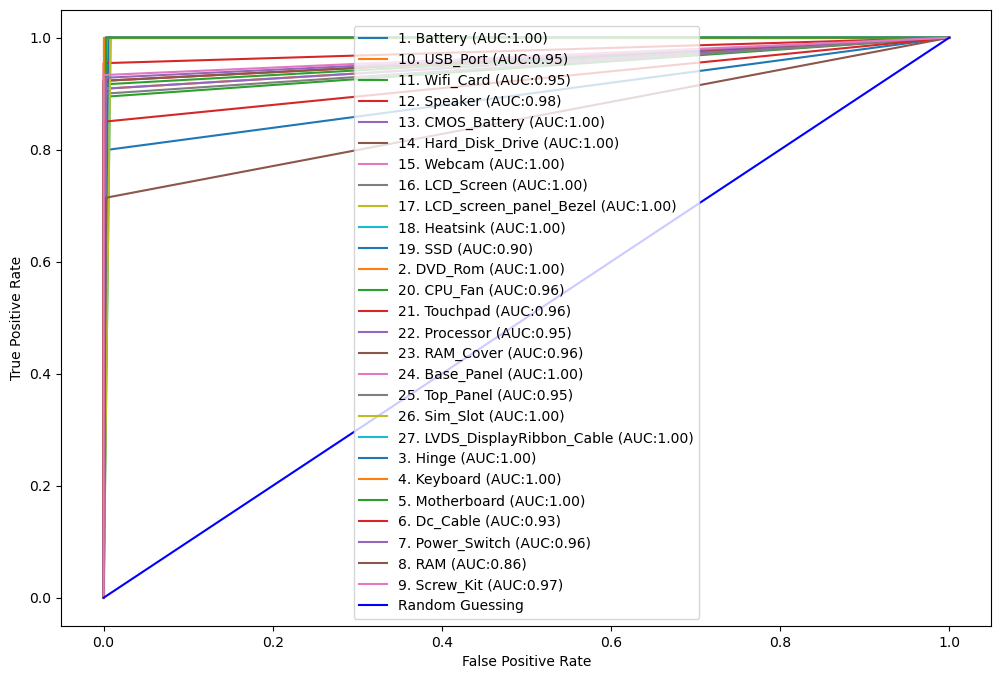

In [116]:
# Set plot figure size
fig, c_ax = plt.subplots(1, 1, figsize=(12, 8))

# Function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, pred, categories, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(pred)

    for (idx, c_label) in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(y_test_bin[:, idx].astype(int), y_pred_bin[:, idx])
        c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))

    c_ax.plot([0, 1], [0, 1], 'b-', label='Random Guessing')
    fig=roc_auc_score(y_test_bin, y_pred_bin, average=average)
    return roc_auc_score(y_test_bin, y_pred_bin, average=average)

# Replace 'categories' with your actual class labels
categories= ['1. Battery', '10. USB_Port',  '11. Wifi_Card', '12. Speaker','13. CMOS_Battery','14. Hard_Disk_Drive',
             '15. Webcam','16. LCD_Screen','17. LCD_screen_panel_Bezel','18. Heatsink','19. SSD', '2. DVD_Rom','20. CPU_Fan',
             '21. Touchpad', '22. Processor','23. RAM_Cover','24. Base_Panel','25. Top_Panel','26. Sim_Slot','27. LVDS_DisplayRibbon_Cable',
             '3. Hinge', '4. Keyboard', '5. Motherboard', '6. Dc_Cable', '7. Power_Switch', '8. RAM', '9. Screw_Kit']

# Assuming 'y_test' and 'pred' are your true labels and predicted probabilities
print('ROC AUC score:', multiclass_roc_auc_score(y_test, pred, categories))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()
fig.savefig("E:/Web/HTMLSection3/400C/Main/DensetNet201/ROC.png")